In [26]:
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML

RAND_SEED = 1
np.random.seed(RAND_SEED)

In [27]:
BASE_PATH = "/SOME_PATH/"

def play_with_date_formats():
    import datetime as dt
    input_formats = ["%A %d %B %Y", "%a %d %B %Y", "%A %d %b %Y", "%a %d %b %Y", "%d/%m/%Y", "%Y%m%d"]
    output_format = "%Y-%m-%d"
    date = dt.datetime.now().date()
    for f in input_formats:
        print("{} => {}".format(date.strftime(output_format), date.strftime(f)))
    
    
play_with_date_formats()

2019-04-02 => Tuesday 02 April 2019
2019-04-02 => Tue 02 April 2019
2019-04-02 => Tuesday 02 Apr 2019
2019-04-02 => Tue 02 Apr 2019
2019-04-02 => 02/04/2019
2019-04-02 => 20190402


#### Create data set

In [28]:
def create_data_set(start_date_str, end_date_str, input_formats, output_format, size):
    import datetime as dt
    start_date = dt.datetime.strptime(start_date_str, output_format).date()
    end_date = dt.datetime.strptime(end_date_str, output_format).date()
    all_dates = [start_date + dt.timedelta(days=i) for i in range ((end_date - start_date).days)]
    
    output = []
    for i in range(size):
        current_date = all_dates[np.random.randint(len(all_dates))]
        input_format = input_formats[np.random.randint(len(input_formats))]
        input_str = current_date.strftime(input_format)
        output_str = current_date.strftime(output_format)
        output.append([input_str, output_str])
    return np.array(output)


input_formats = ["%A %d %B %Y", "%a %d %B %Y", "%A %d %b %Y", "%a %d %b %Y", "%d/%m/%Y", "%Y%m%d"]
data_set = create_data_set("1900-01-01", "2100-12-31", input_formats, "%Y-%m-%d", 100000)
print("Created data set with size: {}, from: {}, to: {}".format(len(data_set), min(list(data_set[:,1])), max(list(data_set[:,1]))))
print("\nSamples:")
for i in data_set[0:10]:
    print(i[0], " => ", i[1])

Created data set with size: 100000, from: 1900-01-01, to: 2100-12-30

Samples:
Sat 21 March 1914  =>  1914-03-21
Thursday 28 October 2100  =>  2100-10-28
05/06/1956  =>  1956-06-05
19210323  =>  1921-03-23
Tue 02 July 1985  =>  1985-07-02
19590729  =>  1959-07-29
29/10/1997  =>  1997-10-29
22/04/2076  =>  2076-04-22
12/08/1954  =>  1954-08-12
Sunday 24 Sep 2056  =>  2056-09-24


#### Functions to create dictionaries and feature vectors

In [29]:
UNKNOWN_INDEX = 0
EOL_INDEX = 1

def create_data_set_dictionaries(data_set):
    return {"input": create_data_set_dictionaries_for(data_set[:,0]), 
            "output": create_data_set_dictionaries_for(data_set[:,1])}

def create_data_set_dictionaries_for(data):
    dic = create_character_dict(data, 2)
    dic.update({"<?>": UNKNOWN_INDEX, "<eol>": EOL_INDEX})
    max_size = max([len(s) for s in data]) + 1
    vec_size = len(dic)
    inv_dic = dict([(v, k) for k, v in dic.items()])
    return {"dict": dic, "max_size": max_size, "vec_size": vec_size, "inv_dict": inv_dic}

def create_character_dict(data, baseIdx = 0):
    unique_chars = set([c for word in data for c in word])
    return dict([(char, baseIdx + i) for i, char in enumerate(unique_chars)])
        
def date_to_vec(date, dictionary):
    max_size = dictionary["max_size"]
    vec_size = dictionary["vec_size"]
    date = date.strip()[0 : vec_size]
    output = np.zeros((max_size, vec_size), dtype="float32")
    for i, c in enumerate(date):
        idx = dictionary["dict"].get(c, UNKNOWN_INDEX)
        output[i] = to_one_hot_vec(idx, vec_size)
    output[i + 1] = to_one_hot_vec(EOL_INDEX, vec_size)
    return output

def vec_to_date(vec, dictionary):
    out = ""
    for one_hot in vec:
        index = one_hot_to_index(one_hot)
        out += dictionary["inv_dict"][index]
        if index == EOL_INDEX:
            return out
    return out

def to_one_hot_vec(index, size):
    v = np.zeros(size, dtype="float32")
    v[index] = 1
    return v

def one_hot_to_index(vec):
    return vec.argmax()
    


dictionaries = create_data_set_dictionaries(data_set)
print("Input dates - Max size: {}, One hot size: {}".format(dictionaries["input"]["max_size"], dictionaries["input"]["vec_size"]))
print("Output dates - Max size: {}, One hot size: {}".format(dictionaries["output"]["max_size"], dictionaries["output"]["vec_size"]))



Input dates - Max size: 28, One hot size: 43
Output dates - Max size: 11, One hot size: 13


#### Create training samples

In [30]:
def create_train_test_set(data_set, dictionaries, trainSetProportion):
    from sklearn.model_selection import train_test_split
    X = np.zeros((len(data_set), dictionaries["input"]["max_size"], dictionaries["input"]["vec_size"]), dtype="float32")
    Y = np.zeros((len(data_set), dictionaries["output"]["max_size"], dictionaries["output"]["vec_size"]), dtype="float32")
    for i, item in enumerate(data_set):
        X[i] = date_to_vec(item[0], dictionaries["input"])
        Y[i] = date_to_vec(item[1], dictionaries["output"])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - trainSetProportion, random_state=RAND_SEED)  
    print("Train set:", X_train.shape, Y_train.shape, X_train.dtype)
    print("Test set:", X_test.shape, Y_test.shape)
    return (X_train, Y_train, X_test, Y_test)
    
    
samples = create_train_test_set(data_set, dictionaries, 0.8)

Train set: (80000, 28, 43) (80000, 11, 13) float32
Test set: (20000, 28, 43) (20000, 11, 13)


#### Train network

In [41]:
def train_model(samples, dictionaries, epochs, batch_size, load_pre_trained_model):
    from keras.layers import Bidirectional, GRU, RepeatVector, TimeDistributed, Dense, Dropout
    import os
    import time
    
    X_train, Y_train, X_test, Y_test = samples
    in_dict = dictionaries["input"]
    out_dict = dictionaries["output"]
    
    # Create Keras model
    model = keras.models.Sequential([
        Bidirectional(GRU(128), input_shape=(in_dict["max_size"], in_dict["vec_size"])),
        RepeatVector(out_dict["max_size"]),
        Bidirectional(GRU(128, return_sequences=True)),
        TimeDistributed(Dense(512, activation="relu")),
        Dropout(0.5),
        TimeDistributed(Dense(out_dict["vec_size"], activation="softmax"))
    ])
    model.summary()
    
    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Callbacks
    def print_progress(epoch, logs):
        print("\tEpoch: {}, Loss: {}%, Val Loss: {}%".format(epoch, round(logs["loss"]*100, 6), round(logs["val_loss"]*100, 6)))
    model_path = BASE_PATH + "models/data_format_pred"
    fit_callbacks = [
        keras.callbacks.ModelCheckpoint(model_path, monitor="loss", save_weights_only=True),
        keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch, logs: print_progress(epoch, logs))
    ]
    
    # Load pre-trained model
    if load_pre_trained_model and os.path.isfile(model_path):
        print("Loading pre-trained model: ", model_path)
        model.load_weights(model_path)
        
    # Train model
    print("Training (epochs: {}, batch: {})...".format(epochs, batch_size))
    start_time = time.time()
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=fit_callbacks, validation_data=(X_test, Y_test))
    elapsed_time_min = (time.time() - start_time) / 60.0
    model.save_weights(model_path)
    print("Done ({} mins)".format(elapsed_time_min))
    
    # Test accuracy
    print("Predicting...")
    score_train = model.evaluate(X_train, Y_train, verbose=0)
    score_test = model.evaluate(X_test, Y_test, verbose=0)
    stats = {
        "training_time_min": elapsed_time_min,
        "train_loss": score_train[0] * 100.0,
        "test_loss": score_test[0] * 100.0,
        "train_acc": score_train[1] * 100.0,
        "test_acc": score_test[1] * 100.0,
    }
    print("Train set - Loss: {}%, Accuracy: {}%".format(round(stats["train_loss"], 4), round(stats["train_acc"], 4)))
    print("Test set - Loss: {}%, Accuracy: {}%".format(round(stats["test_loss"], 4), round(stats["test_acc"], 4)))
    
    # Plot training
    plot_training_progress(history)
    
    return (model, history, stats)

def plot_training_progress(history):
    from matplotlib import pyplot as plt
    def plot(title, x_axis_label, y_axis_label, y_label, y_data, y_val_label, y_val_data):
        x = np.arange(len(y_data))
        fix, ax = plt.subplots(1,1, figsize=(20,8))
        plt.scatter(x, y_data, c="red", label=y_label)
        plt.plot(x, y_data, color="red")
        plt.scatter(x, y_val_data, c="blue", label=y_val_label)
        plt.plot(x, y_val_data, color="blue")
        plt.title(title)
        plt.xlabel(x_axis_label)
        plt.ylabel(y_axis_label)
        plt.legend()
        plt.show
    y_loss = np.array(history.history["loss"]) * 100.0
    y_val_loss = np.array(history.history["val_loss"]) * 100.0
    y_acc = np.array(history.history["acc"]) * 100.0
    y_val_acc = np.array(history.history["val_acc"]) * 100.0
    plot("Training progress - Loss", "Epochs", "Loss", "Train loss", y_loss, "Val loss", y_val_loss)
    plot("Training progress - Accuracy", "Epochs", "Loss", "Train acc", y_loss, "Val acc", y_val_loss)
        
def predict_format(dates, dictionaries, model):
    tot_dates = len(dates)
    X = np.zeros((tot_dates, dictionaries["input"]["max_size"], dictionaries["input"]["vec_size"]), dtype="float32")
    for i, date in enumerate(dates):
        X[i] = date_to_vec(date, dictionaries["input"])
        
    Y_pred = model.predict(X)
    output = []
    for i, date in enumerate(dates):
        date_pred = vec_to_date(Y_pred[i], dictionaries["output"])
        output.append({"date_input": date, "date_pred": date_pred})
    return output
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 256)               132096    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 11, 256)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 11, 256)           295680    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 11, 512)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 512)           0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 11, 13)            6669      
Total params: 566,029
Trainable params: 566,029
Non-trainable params: 0
_________________________________________________________________
Trai

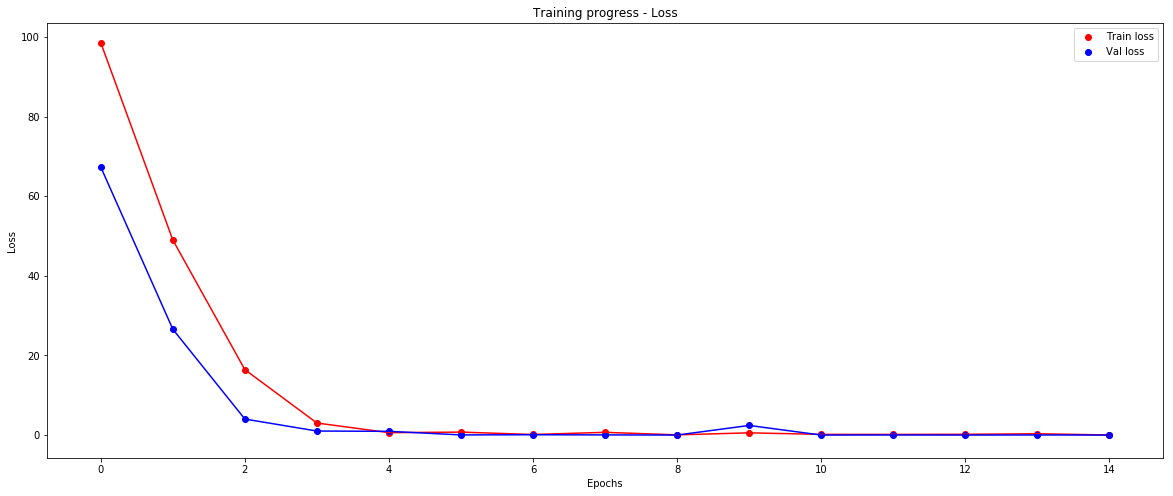

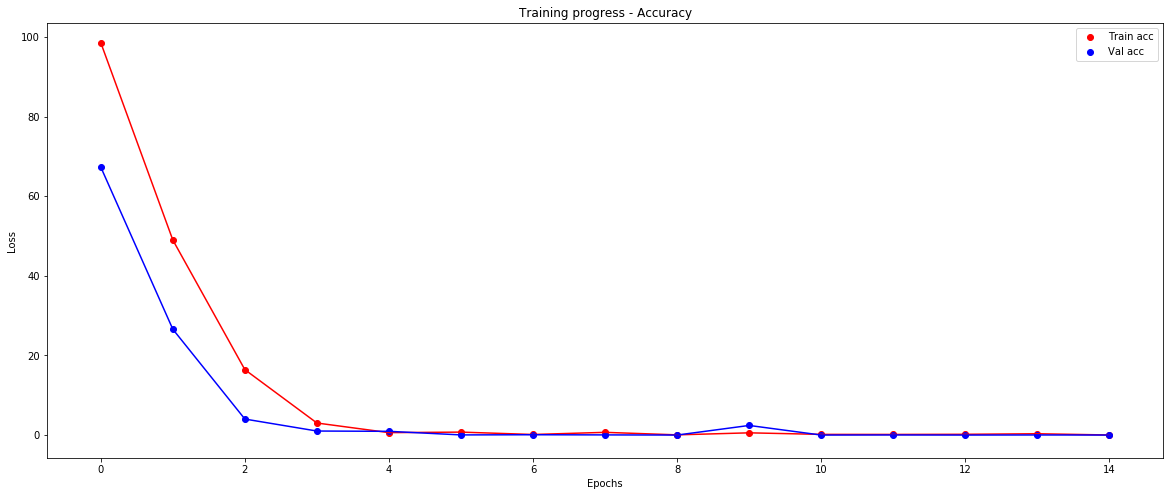

In [39]:
train_results = train_model(samples, dictionaries, 15, 128, False)

In [43]:
dates_to_predict = [
    "Saturday 02 January 2015",
    "Monday 13 March 2017",
    "Wed 29 Jul 1985"
]
predict_format(dates_to_predict, dictionaries, train_results[0])

[{'date_input': 'Saturday 02 January 2015', 'date_pred': '2015-01-02<eol>'},
 {'date_input': 'Monday 13 March 2017', 'date_pred': '2017-03-13<eol>'},
 {'date_input': 'Wed 29 Jul 1985', 'date_pred': '1985-07-29<eol>'}]